In [44]:
# import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [45]:
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import train_test_split

In [46]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [47]:
from os import listdir
from os.path import isfile, join

In [48]:
# not sure the real size
width = 450
hieght = 550

In [154]:
df = pd.read_excel(r"D:\Jiw\work\01-school-Work\01-classroom-Work\02-SciProj\Sci-project-m5\data\cdi-data-scan1266.xlsx", sheet_name="depressed-data")
# df = df[["ID","Pt","DEP","Age","Sex"]] #1 = depressed

In [105]:
df

,QuizName,ZipGradeID,ID,Age,Sex,DEP,Pt,PossiblePts,PercentCorrect,QuizCreated,...,PossPt25,Stu26,Key26,EarnedPt26,PossPt26,Stu27,Key27,EarnedPt27,PossPt27,NULL
0,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,1130,1,13,0,0,7,27,29.6,เธก.เธ. 19 2024 03:39 PM,...,1,A,B,0,1,A,B,0,1,0
1,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,2120,2,12,0,1,16,27,55.6,เธก.เธ. 19 2024 03:36 PM,...,1,B,B,1,1,B,B,1,1,0
2,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,3121,3,12,1,0,7,27,29.6,เธก.เธ. 19 2024 03:36 PM,...,1,A,B,0,1,A,B,0,1,0
3,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,4131,4,13,1,0,12,27,48.1,เธก.เธ. 19 2024 03:37 PM,...,1,A,B,0,1,A,B,0,1,0
4,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,5120,5,12,0,0,14,27,55.6,เธก.เธ. 19 2024 03:36 PM,...,1,A,B,0,1,A,B,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,543150,543,15,0,1,22,27,85.2,เธก.เธ. 18 2024 04:35 PM,...,1,B,B,1,1,B,B,1,1,0
474,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,544151,544,15,1,0,5,27,22.2,เธก.เธ. 18 2024 04:35 PM,...,1,A,B,0,1,A,B,0,1,0
475,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,545150,545,15,0,1,27,27,103.7,เธก.เธ. 18 2024 04:35 PM,...,1,B,B,1,1,A,B,0,1,0
476,เนเธเธเธเธฑเธ”เธเธฃเธญเธเธเธถเธกเน€เธจเ...,546111,546,11,1,0,12,27,48.1,เธก.เธ. 18 2024 04:35 PM,...,1,A,B,0,1,A,B,0,1,0


In [137]:
keys = []
keys.append("Age")
keys.append("Sex")
keys

['Age', 'Sex']

In [152]:
def labelfeatures(ID):
    i = df['Pt'][df['ID']==ID].index
    # score = df.loc[0, "Pt"]
    score = df.loc[i[0], keys]
    score.to_numpy()
    return score

def labelY(ID):
    i = df['Pt'][df['ID']==ID].index
    # score = df.loc[0, "Pt"]
    y = df.loc[i[0], "Pt"]
    return y

In [139]:
def img2flattened(path):
  img_data = []
  IDs = []
  # features = []
  Y = []

  for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for item in tqdm(os.listdir(folder_path)):
      filePath = os.path.join(folder_path, item)

      # print(item)
      ID = int((item.split('.')[0]).split('-')[1])
      #ID = int(item.split('.')[0])
      IDs.append(ID)
      # features.append(labelfeatures(ID))
      Y.append(labelY(ID))

      img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
      # plt.imshow(img)

      img = cv2.resize(img , (width, hieght))
      flatten_img = img.flatten()

      img_data.append(flatten_img)
      # print(flatten_img)

  return img_data, IDs, Y

In [158]:

labelY(2)

16

In [160]:
def img2feature_extract(path, model):
  img_data = []
  IDs = []
  # features = []
  Y = []

  for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for item in tqdm(os.listdir(folder_path)):
      filePath = os.path.join(folder_path, item)

      #print(item)
      ID = int((item.split('.')[0]).split('-')[1])
      #ID = int(item.split('.')[0])
      #print(ID)

      IDs.append(ID)
      # features.append(labelfeatures(ID))
      Y.append(labelY(ID))

      img = cv2.imread(filePath, cv2.IMREAD_COLOR)
      # plt.imshow(img)

      img = cv2.resize(img , (224, 224))
      img = np.reshape(img, (-1, 224, 224, 3))

      
      
      processed_img = preprocess_input(img)
      features = model.predict(processed_img, verbose=0)
      #print(features)
      img_data.append(features[0])
      # print(flatten_img)

  return img_data, IDs, Y


In [141]:
# feature extracter model
feature_extract_model = VGG16()
feature_extract_model = Model(inputs=feature_extract_model.inputs, outputs=feature_extract_model.layers[-2].output)

In [161]:
path = r"D:\Jiw\work\01-school-Work\01-classroom-Work\02-SciProj\Sci-project-m5\Unprocessed-data\Saperate-part-img\leg"
#flattened_images, img_name, Y = img2flattened(path)
feature_extract_images, img_name , Y = img2feature_extract(path, feature_extract_model)

#flattened_images = np.asarray(flattened_images)
feature_extract_images = np.asarray(feature_extract_images)

# flattened_images = img.reshape(img.shape[0], -1)

100%|██████████| 279/279 [01:20<00:00,  3.48it/s]


In [162]:
# analyze with images only
images_train = feature_extract_images
images_train.shape

(462, 4096)

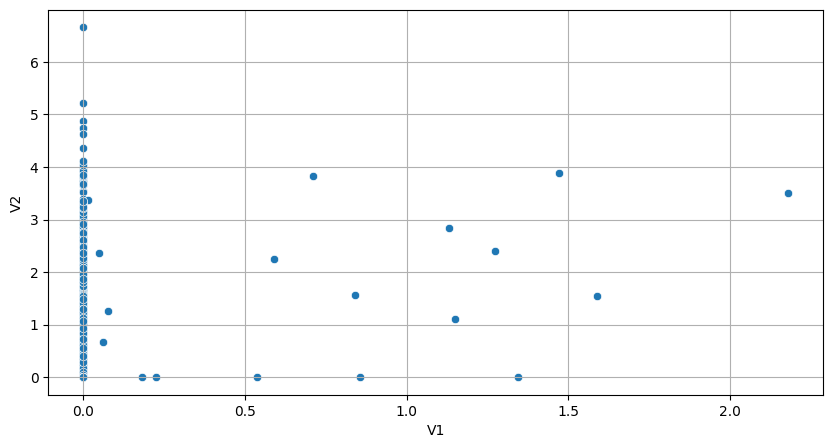

In [163]:
import seaborn as sb
import matplotlib.pyplot as plt
dimReducedDataFrame = pd.DataFrame(images_train)
dimReducedDataFrame = dimReducedDataFrame.rename(columns = { 0: 'V1', 1 : 'V2'})
#dimReducedDataFrame['Category'] = [[0],[1]]
plt.figure(figsize = (10, 5))
sb.scatterplot(data = dimReducedDataFrame, x = 'V1', y = 'V2')
plt.grid(True)
plt.show()

In [164]:
k = 2

In [165]:
kmeans = KMeans(k, random_state = 40)
kmeans.fit(images_train)

C:\Users\Computer\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=40)

In [166]:
birch = Birch(threshold=0.5, n_clusters=k)
birch.fit(images_train)

Birch(n_clusters=2)

In [167]:
gaussian = GaussianMixture(n_components=k, random_state=40)
gaussian.fit(images_train)

GaussianMixture(n_components=2, random_state=40)

In [168]:
amt = AgglomerativeClustering(n_clusters=k)
amt.fit(images_train)

AgglomerativeClustering()

In [169]:
afp = AffinityPropagation(damping=0.5)
afp.fit(images_train)

AffinityPropagation()

In [170]:
image_cluster = pd.DataFrame(img_name, columns=['image'])

In [171]:
def labelscore(ID):
    
    i = df['Pt'][df['ID']==ID].index
    score = df.loc[i[0], 'Pt']
    return score

In [172]:

image_cluster["BIRCH-cluster"] = birch.labels_
image_cluster["KMeans-cluster"] = kmeans.labels_
image_cluster["Gaussian-cluster"] = gaussian.predict(images_train)
image_cluster["Agglomerative-cluster"] = amt.labels_
image_cluster["AffinityPropagation"] = afp.labels_
image_cluster["score"] = Y
image_cluster

,image,BIRCH-cluster,KMeans-cluster,Gaussian-cluster,Agglomerative-cluster,AffinityPropagation,score
0,2,0,1,1,0,16,16
1,12,0,1,1,0,24,39
2,15,0,1,1,0,0,15
3,17,0,1,1,0,9,28
4,18,0,1,1,1,18,15
...,...,...,...,...,...,...,...
457,539,1,0,0,1,12,6
458,540,1,0,0,1,26,14
459,541,0,1,1,0,24,2
460,544,0,0,0,0,31,5


In [173]:
def labelClass(ID):
    
    i = df['DEP'][df['ID']==ID].index
    score = df.loc[i[0], 'DEP']
    return score

def clusterClass(ID):
    i = image_cluster['clusterid'][image_cluster['image']==ID].index
    # print(i)
    score = image_cluster.loc[i[0], 'clusterid']
    return score

In [174]:
y_true = []

for id in image_cluster['image']:
    y_true.append(labelClass(id))

In [175]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, davies_bouldin_score,calinski_harabasz_score, silhouette_score


In [176]:

for Ypred in image_cluster.columns[1:6]:
    print(Ypred)
    print(f"")
    print(f"davies_bouldin_score : {davies_bouldin_score(images_train, image_cluster[Ypred])}")
    print(f"calinski_harabasz_score : {calinski_harabasz_score(images_train, image_cluster[Ypred])}")
    print(f"silhouette_score : {silhouette_score(images_train, image_cluster[Ypred])}")

    print(f"normalized_mutual_info_score : {normalized_mutual_info_score(y_true, image_cluster[Ypred])}")
    print(f"accuracy_score : {accuracy_score(y_true, image_cluster[Ypred])}")
    print(f"F1-score : {f1_score(y_true, image_cluster[Ypred])}")
    print(f"")

BIRCH-cluster

davies_bouldin_score : 3.264285653697756
calinski_harabasz_score : 37.27716183620617
silhouette_score : 0.07051707059144974
normalized_mutual_info_score : 0.0012640525354245718
accuracy_score : 0.512987012987013
F1-score : 0.34402332361516036

KMeans-cluster

davies_bouldin_score : 3.0966797235691406
calinski_harabasz_score : 46.386476873617376
silhouette_score : 0.0847904309630394
normalized_mutual_info_score : 0.0006156653504093592
accuracy_score : 0.5173160173160173
F1-score : 0.45208845208845205

Gaussian-cluster

davies_bouldin_score : 3.0962984917707366
calinski_harabasz_score : 46.1970483373713
silhouette_score : 0.08628792315721512
normalized_mutual_info_score : 8.112751790496705e-05
accuracy_score : 0.5043290043290043
F1-score : 0.4173027989821883

Agglomerative-cluster

davies_bouldin_score : 3.3266993727578593
calinski_harabasz_score : 36.561191543166885
silhouette_score : 0.06836771965026855
normalized_mutual_info_score : 0.00048807174877155796
accuracy_score

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

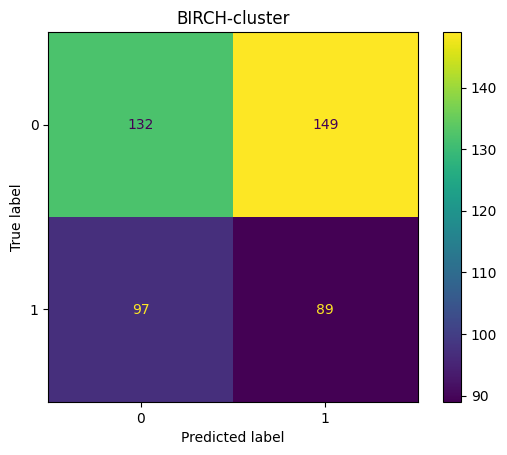

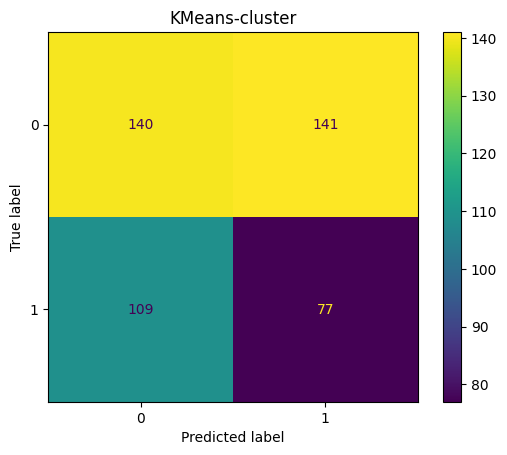

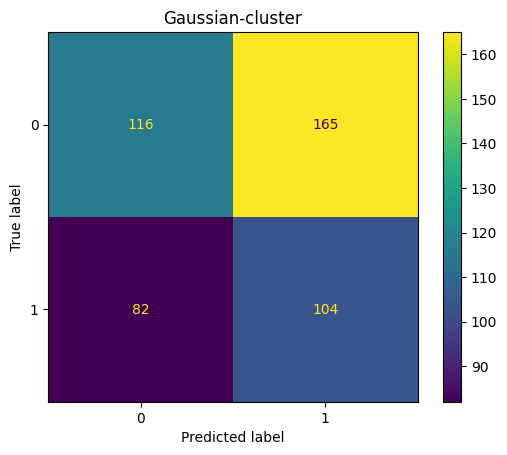

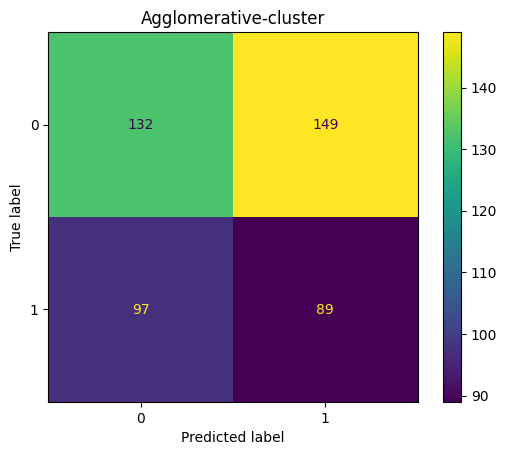

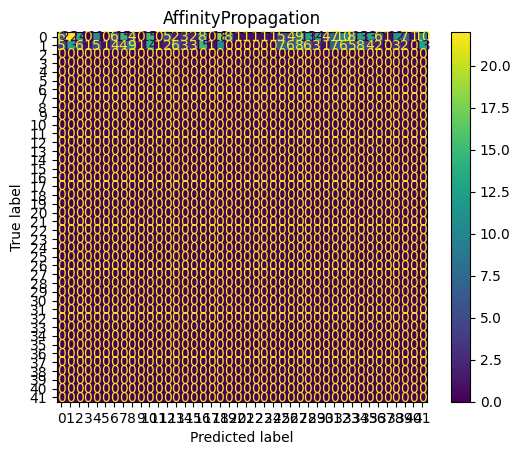

In [ ]:
for Ypred in image_cluster.columns[1:6]:
    cm = confusion_matrix(y_true, image_cluster[Ypred])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot()
    plt.title(Ypred)
    plt.show()
    

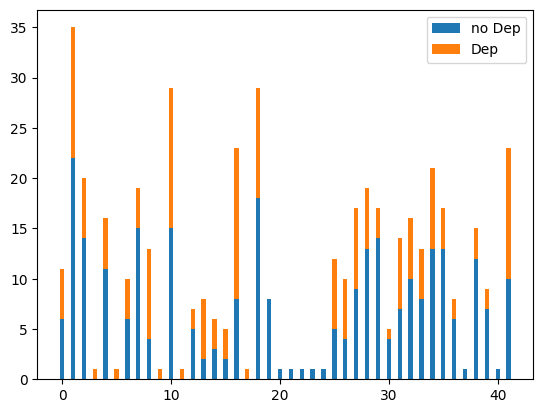

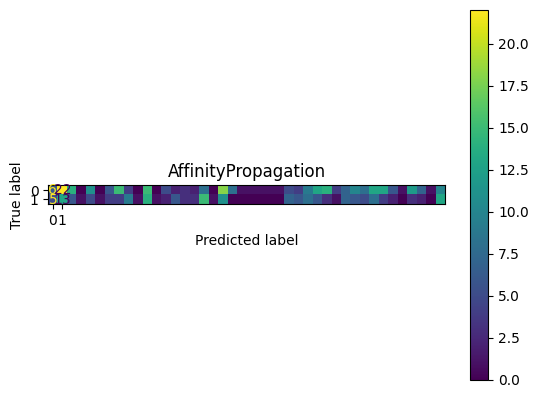

In [ ]:
Ypred = image_cluster.columns[-2]
cm = confusion_matrix(y_true, image_cluster[Ypred])

df = pd.DataFrame(cm).head(2)

plt.bar(range(0,42), cm[0,:],0.4, label="no Dep")
plt.bar(range(0,42), cm[1,:],0.4, bottom=cm[0,:], label="Dep")
plt.legend()

cm = df.to_numpy() 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title(Ypred)
plt.show()

In [ ]:
# name_cluster = (
#     "Cluster 0",
#     "Cluster 1",
# )
# weight_counts = {
#     "dep": cm[0],
#     "no-dep": cm[1],
# }
# width = 0.5

# fig, ax = plt.subplots()
# bottom = np.zeros(2)

# for boolean, weight_count in weight_counts.items():
#     p = ax.bar(name_cluster, weight_count, width, label=boolean, bottom=bottom)
#     bottom += weight_count

# ax.set_title("Number of depressed in each cluster")
# ax.legend(loc="upper right")

# plt.show()

In [ ]:
# centroids = kmeans.cluster_centers_
# centroids

In [ ]:
# plt.scatter(image_cluster["score"], images_score[:, 0], c= image_cluster["cluster"], cmap='viridis')
# plt.scatter( centroids[:, 1], centroids[:, 0], s=200, c='red', marker='x')
# plt.title('K-Means Clustering')
# plt.xlabel('color mean')
# plt.ylabel('CDI score')
# plt.show()

In [ ]:
#visulaize

# fig = plt.figure(figsize=(300, 100))
# rows = 15
# columns = 40 
# i = 0
# for ID in image_cluster["image"][image_cluster['cluster']==1][244:]:
#     i += 1
#     name = str(ID).rjust(3, '0')
#     folname = labelClass(ID)

#     if folname == 0:
#         folname = "Depressed"
#     else:
#         folname = "No-Depressed"
#     # 0 = dep
#     # 1 = no-dep

#     image = cv2.imread(f'data_label\\{folname}\\{name}.jpg') 
#     fig.add_subplot(rows, columns, i) 

#     plt.imshow(image) 
#     plt.axis('off') 